In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
TRAIN_PATH = './training.csv'
TEST_PATH = './test.csv'

def load_data(is_test=False, cols=None):
    """
    기본적으로는 Training 데이터를 로드하되, 테스트 데이터를 로드할 경우에는 is_test 옵션을 준다
    기본적으로 Image 칼럼만 가져오는데, 원하는 칼럼의 경우 cols 에 리스트를 넘긴다
    """
    file_path = TEST_PATH if is_test else TRAIN_PATH
    df = pd.read_csv(file_path)
    # print(df.info())
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        # 만약 더 담을 칼럼이 있다면, 추가해준다
        df = df[list(cols)+['Image']]
    # print(df.count()) # print the number of values for each columns
    df.dropna(inplace=True)
    
    X = np.vstack(df['Image'].values) / 255 # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    
    if not is_test:
        # only training data processing
        y = df[df.columns[:-1]].values
        y = (y-48)/48 # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42) # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X, y

In [3]:
def load_2d_shape(is_test=False, cols=None):
    X, y = load_data(is_test=is_test)
    print('X.shape from load_data ',X.shape)
    X = X.reshape(-1, 1, 96, 96) 
    print('X.shape from reshape ',X.shape)
    return X, y

In [4]:
def plot_sample(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48 + 48, y[1::2]*48 + 48, marker='x', s=10)
    axis.axis('off')

def draw_multi_plot(X, y, row_num=4, col_num=4, fig_size=(15,10)):
    fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=fig_size)
    i=0
    for row in axes:
        for each_ax in row:
            plot_sample(X[i], y[i], each_ax)
            i += 1
    plt.tight_layout()

In [5]:
X, y = load_2d_shape()

X.shape from load_data  (2140, 9216)
X.shape from reshape  (2140, 1, 96, 96)


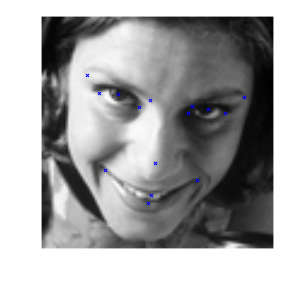

In [6]:
fig, ax = plt.subplots()
plot_sample(X[1], y[1], ax)
plt.tight_layout()

In [7]:
def make_config():
    config_dict = {
        "nb_epoch":10,
        "batch_size":128,
        "img_rows":96,
        "img_cols":96,
        "nb_filters_1":32,
        "nb_filters_2":64,
        "nb_filters_3":128,
        "nb_conv":3
    }
    return config_dict

In [8]:
config = make_config()

In [13]:
import keras.models as models
import keras.layers.convolutional as conv
import keras.layers.core as core
from keras.optimizers import SGD

In [16]:
cnn = models.Sequential()
cnn

### 만약 input_shape 에서 (1, 96, 96) 에러가 난다면, Keras 설정파일의 input_dim 의 타입의 종류를 tf -> th 로 바꿔주어야 한다.
### Keras 설정파일은 나의 경우에는 ~/.keras/ 아래에 json 파일로 있었다.

In [17]:
cnn.add(conv.Convolution2D(config['nb_filters_1'], config['nb_conv'], config['nb_conv'], activation='relu', input_shape=(1, 96, 96), border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2,2)))
cnn.add(core.Dropout(0.2))

cnn.add(conv.Convolution2D(config['nb_filters_2'], 3, 3, activation='relu', border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2,2)))

cnn.add(core.Flatten())
cnn.add(core.Dropout(0.5))
cnn.add(core.Dense(500, activation='relu'))
cnn.add(core.Dense(500, activation='relu'))
cnn.add(core.Dense(30)) # softmax 에 넣고 클래스를 분류할 수 있도록 한다

In [18]:
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 96, 96)    320         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 48, 48)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 32, 48, 48)    0           maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 64, 48, 48)    18496       dropout_3[0][0]                  
___________________________________________________________________________________________

In [19]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
cnn.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
cnn

In [20]:
cnn.fit(X, y, nb_epoch=config['nb_epoch'], verbose=1)

Epoch 1/10
2140/2140 [==============================] - 149s - loss: 0.0248 - acc: 0.5332   
Epoch 2/10
2140/2140 [==============================] - 155s - loss: 0.0063 - acc: 0.6584   
Epoch 3/10
2140/2140 [==============================] - 139s - loss: 0.0053 - acc: 0.6794   
Epoch 4/10
2140/2140 [==============================] - 140s - loss: 0.0052 - acc: 0.6808   
Epoch 5/10
2140/2140 [==============================] - 139s - loss: 0.0051 - acc: 0.6949   
Epoch 6/10
2140/2140 [==============================] - 139s - loss: 0.0050 - acc: 0.6897   
Epoch 7/10
2140/2140 [==============================] - 1167s - loss: 0.0049 - acc: 0.6930   
Epoch 8/10
2140/2140 [==============================] - 143s - loss: 0.0048 - acc: 0.6949   
Epoch 9/10
2140/2140 [==============================] - 141s - loss: 0.0048 - acc: 0.6981   
Epoch 10/10
2140/2140 [==============================] - 139s - loss: 0.0048 - acc: 0.6972   


In [21]:
y_pred = cnn.predict(X)
y_pred

array([[ 0.31992409, -0.18467899, -0.31539974, ...,  0.43515339,
         0.00183275,  0.61031997],
       [ 0.32382548, -0.20627412, -0.31848782, ...,  0.44651964,
         0.00679203,  0.63003385],
       [ 0.31025031, -0.18466461, -0.3050282 , ...,  0.42519918,
         0.00330089,  0.59606183],
       ..., 
       [ 0.32057762, -0.19177918, -0.31517553, ...,  0.42979589,
         0.00402719,  0.62191534],
       [ 0.33200237, -0.20348209, -0.32230029, ...,  0.44943249,
         0.00114776,  0.63233042],
       [ 0.34023598, -0.20386101, -0.33698955, ...,  0.45855957,
         0.00719335,  0.66136086]], dtype=float32)

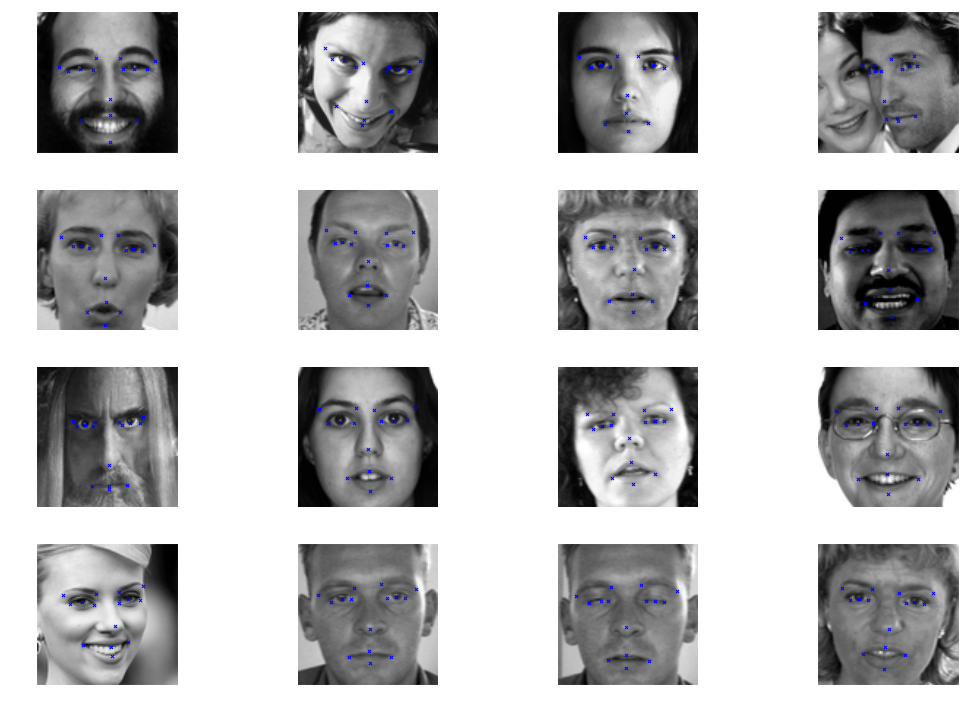

In [22]:
draw_multi_plot(X, y)

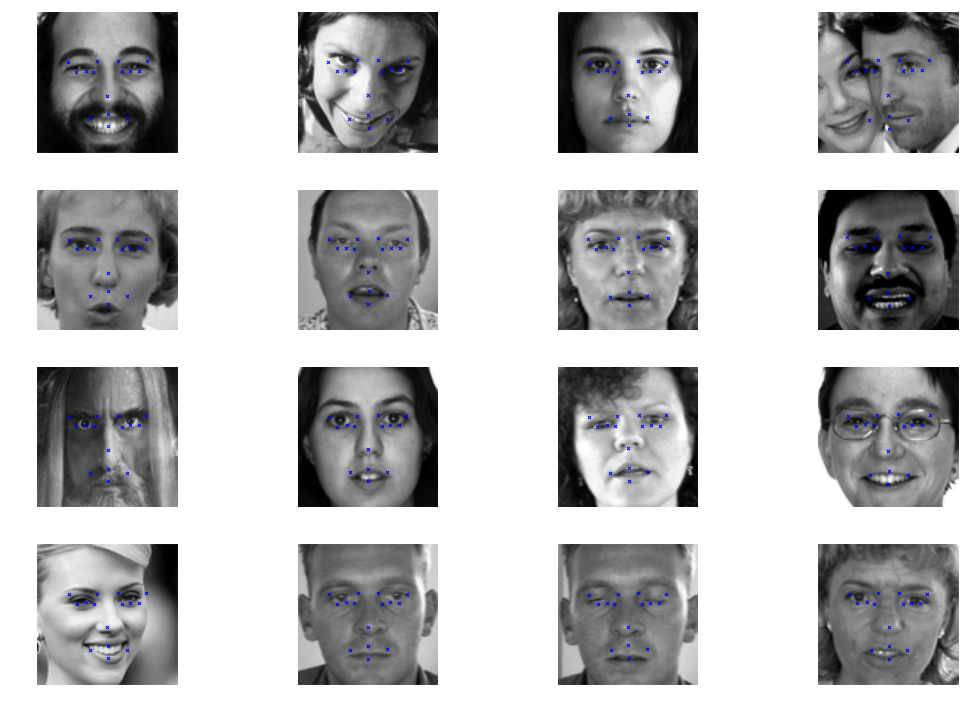

In [23]:
draw_multi_plot(X, y_pred)